# Ancillary external photometry

This tutorial shows how to use external photometric data to perform astrometry calibrations on a Cube

In [5]:
%load_ext autoreload
%autoreload 2

In [11]:
from matplotlib import pyplot as plt
import numpy as np

from pykoala.cubing import Cube

cube = Cube(file_path="products/Henize_2-10_cube_no_sky.fits.gz",
            hdul_extensions_map={"INTENSITY": "INTENSITY", "VARIANCE": "VARIANCE"})

# Read the sky position and cube pixel size from the header
he2_10_ra, he2_10_dec = cube.wcs.celestial.wcs.crval[:2]
cube_pix_area = (cube.wcs.celestial.wcs.cdelt[0] * 3600)**2
print(f"Cube position: RA={he2_10_ra}, DEC={he2_10_dec}")
print("Cube pixel area (arcsec^2) ", cube_pix_area)

[Cube] Loading HDUL products/Henize_2-10_cube_no_sky.fits.gz
[Cube] Reading WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Log]  Initialising history log
[Cube] Looking for information in the primary header
[Cube] Constructing wavelength array
1 0 5 6
Cube position: RA=0.0, DEC=0.0
Cube pixel area (arcsec^2)  1.000000000000016


In [7]:
cube.log.dump_to_header()

PYKOALA0= '0.8.0+14.gb70d00e.dirty' / PyKOALA version                           

In [9]:
from pykoala.corrections.external_data import AncillaryDataCorrection

anc_data_corr = AncillaryDataCorrection([cube])

# Query r-band photometry from PS using a cutout with the size of the input cube
# + 30 additional arcseconds on every side. Save the fits in the current working directory
anc_data_corr.query_image(survey='PS', filters='i', im_extra_size_arcsec=30, im_output_dir='.')

SyntaxError: invalid syntax (external_data.py, line 107)

Once the ancillary data is ready, we can perform the cross-correlation between the two data sets by matching the fluxes of a set of apertures. First, we need to compute a set of apertures using our input DC intensities. In this case, we provided a Cube and then the apertures will be computed using the WCS information. If we provide an RSS, the apertures will correspond to the flux contained on each fibre.

To compute the DC photometry, we can call the method `get_dc_aperture_fluxes`. As arguments we will pass the aperture diameter in arcseconds and the filter names to be used (this must match those of the ancillary data). To control the number of apertures that are computed, we can say how many apertures are needed per aperture diameter using `sample_every` (i.e., if we want consecutive apertures we can set it to `1`, whereas one aperture every 4 diameters -- 5 arcsec in this example -- would correspond to `sample_every=4`).


In [3]:
# Produce synthetic r-band photometry using the cube spectra and measure apertures.
dc_photometry = anc_data_corr.get_dc_aperture_fluxes(
    aperture_diameter=1.25, sample_every=2, filter_names=["PANSTARRS_PS1.i"])

NameError: name 'anc_data_corr' is not defined

The result is stored in the attribute `dc_photometry`, a dictonary with entries corresponding to different filters. See the documentaion provided in `get_dc_aperture_fluxes` for a complete description.

The synthetic image produced from a data cube can be visualized using the key `synth_photo`

In [4]:
plt.figure(figsize=(8, 4), constrained_layout=True)
plt.subplot(121, title='Synthetic PANSTARRS-i photometry',
            projection=dc_photometry['PANSTARRS_PS1.i']['wcs'][0])
plt.imshow(- 2.5 * np.log10(dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0] / 3631),
           interpolation='none', vmin=17, vmax=25, cmap='Spectral')
plt.colorbar(label=r"$m_{\rm AB}$ (dex)", extend='both')
plt.subplot(122, title='Error',
            projection=dc_photometry['PANSTARRS_PS1.i']['wcs'][0])
plt.imshow(2.5 / np.log(10) * dc_photometry['PANSTARRS_PS1.i']['synth_photo_err'][0] / dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0],
           interpolation='none', vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(label="Error (dex)", extend='both')

NameError: name 'plt' is not defined

The aperture fluxes are stored in `aperture_flux`. A summary figure with the synthetic photometry and the aperture fluxes is stored for each DC in `figs`.

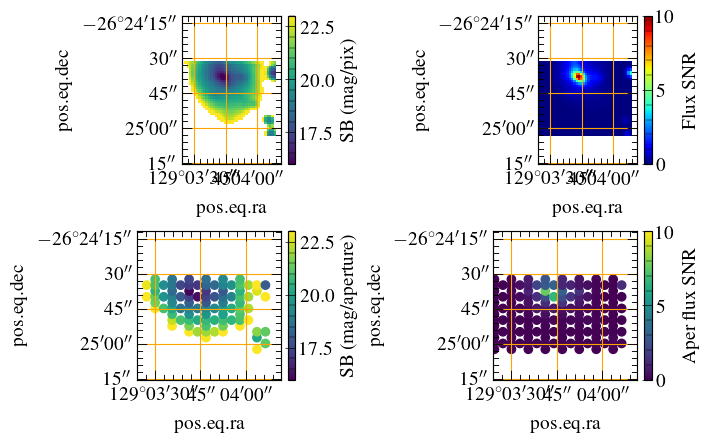

In [90]:
dc_photometry['PANSTARRS_PS1.i']['figs'][0]

Now we can compare the synthetic photometry with the ancillary reference data and derive an astrometric correction. For this, we can make use of the method `get_astrometry_offset`. This function will perform a cross-correlation between both data sets by creating apertures on the ancillary image and comparing them to the reference data. On each iteration, the apertures are placed on a position with an offset with respect to the expected location (given by the DC WCS). Once the sampling is done, the method provides the solution that minimizes the residuals and the mean averaged one. 

In [91]:
results = anc_data_corr.get_astrometry_offset()


[Correction: AncillaryData] Computing astrometric offsets
Cross-correlating image to list of apertures
Input number of apertures:  152
Computing the offset solution


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:549: RuntimeWarning: invalid value encountered in log10
  synt_sb = -2.5 * np.log10(ref_image / 3631)
/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:550: RuntimeWarning: invalid value encountered in log10
  im_sb = -2.5 * np.log10(image['intensity'] / 3631 / image['pix_size']**2)


We can visualize the results of the sampling by checking the following figure

dict_keys(['offset_min', 'offset_mean', 'ra_offset', 'dec_offset', 'sampling', 'weights', 'fig', 'offset_fig'])


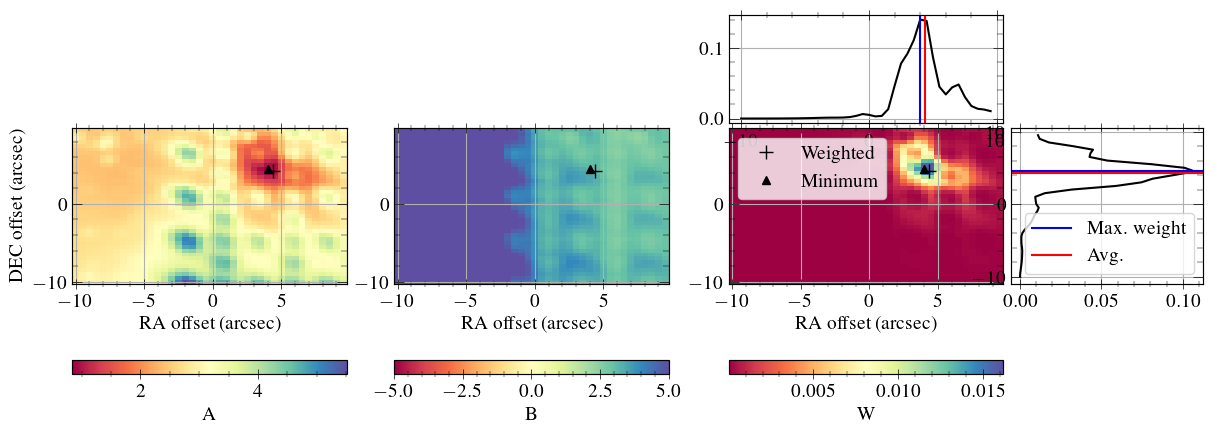

In [92]:
print(results[0]['PANSTARRS_PS1.i'].keys())

results[0]['PANSTARRS_PS1.i']['fig']

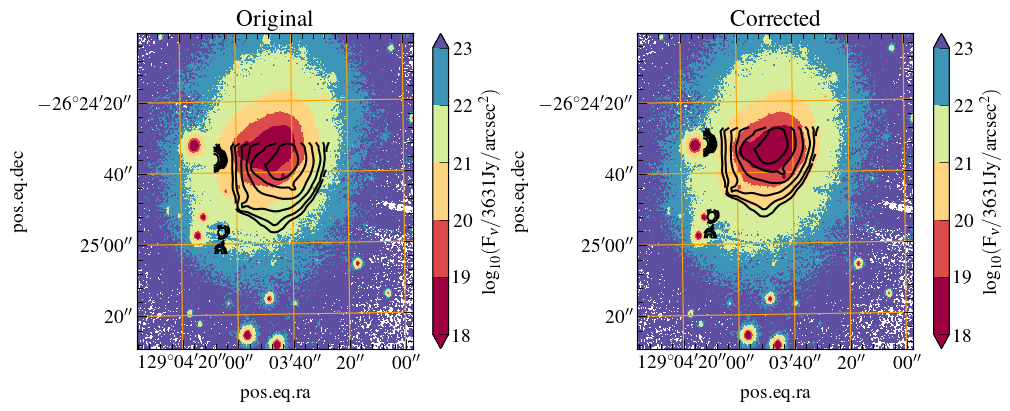

In [93]:
plt.figure(results[0]['PANSTARRS_PS1.i']['offset_fig'])

If the result is acceptable, we can then apply this correction to the Data Container

In [94]:
ra_dec_offset = results[0]['PANSTARRS_PS1.i']['offset_mean']
print(ra_dec_offset)

cube = anc_data_corr.apply(cube, ra_dec_offset)

(4.35630361720664, 4.253331004079518)
[Correction: AncillaryData] Applying astrometry offset correction to DC (RA, DEC):  (4.35630361720664, 4.253331004079518)
Previous CRVAL:  [129.06270331 -26.41271784] 
New CRVAL:  [129.0639134  -26.41153636]
[Log]  Logging entry > update_coords:Offset-coords updated


In [95]:
- 2.5 * np.log10(dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0] / 3631)

/tmp/ipykernel_186994/2450473948.py:1: RuntimeWarning: invalid value encountered in log10
  - 2.5 * np.log10(dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0] / 3631)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/tmp/ipykernel_186994/1313960271.py:3: RuntimeWarning: invalid value encountered in log10
  qc_external_image(- 2.5 * np.log10(dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0] / 3631),
/tmp/ipykernel_186994/1313960271.py:5: RuntimeWarning: invalid value encountered in log10
  -2.5 * np.log10(anc_data_corr.images['PANSTARRS_PS1.i']['intensity'] / 0.25**2 / 3631),


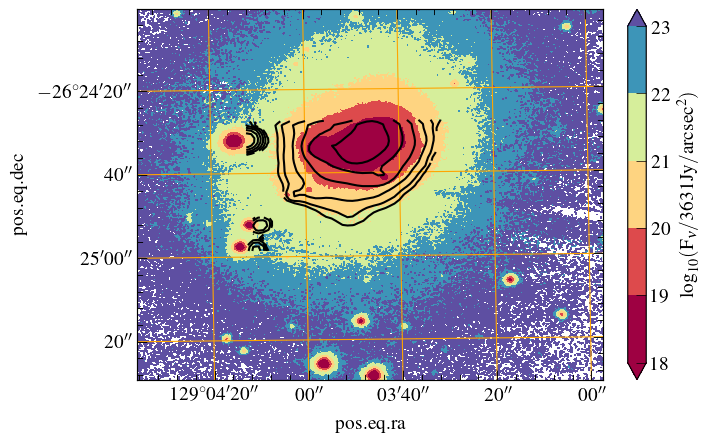

In [99]:
from pykoala.plotting.qc_plot import qc_external_image

qc_external_image(- 2.5 * np.log10(dc_photometry['PANSTARRS_PS1.i']['synth_photo'][0] / 3631),
                  cube.wcs.celestial,
                 -2.5 * np.log10(anc_data_corr.images['PANSTARRS_PS1.i']['intensity'] / 0.25**2 / 3631),
                 anc_data_corr.images['PANSTARRS_PS1.i']['wcs'])


In [100]:
# Save the final version of the cube
cube.to_fits("products/Henize_2-10_cube_astrometry.fits.gz")

KeyError: 'kernel_size_arcsec'